# GW Response Tutorial Notebook

In [87]:
import gw_response as gwr
import sys

print("Running on:", sys.version)

Running on: 3.9.18 | packaged by conda-forge | (main, Dec 23 2023, 16:35:41) 
[Clang 16.0.6 ]


In [88]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

GENERATE_TEST_DATA = False

## Module: `constants`

Contains dataclasses for standard physical constants and TDI basis transformations

In [89]:
ps = gwr.PhysicalConstants()
print("Object:", ps)
print("Example (c in m/s):", ps.light_speed)

Object: PhysicalConstants(light_speed=299792458.0, hour=3600.0, day=86400.0, yr=31557600.0, Hubble_over_h=3.24e-18, AU=149597870700.0, cmb_dipole=Array([-0.972,  0.137, -0.191], dtype=float64))
Example (c in m/s): 299792458.0


In [90]:
basis_transformation = gwr.BasisTransformations()
# Currently only XYZ to AET implemented
print("Object:", basis_transformation)
print("Example (XYZ to AET):\n", basis_transformation.XYZ_to_AET)

Object: BasisTransformations(XYZ_to_AET=Array([[-0.70710678,  0.        ,  0.70710678],
       [ 0.40824829, -0.81649658,  0.40824829],
       [ 0.57735027,  0.57735027,  0.57735027]], dtype=float64))
Example (XYZ to AET):
 [[-0.70710678  0.          0.70710678]
 [ 0.40824829 -0.81649658  0.40824829]
 [ 0.57735027  0.57735027  0.57735027]]


## Module: `detector`

Contains an abstract base class implementation of a `Detector` object

In [91]:
class MyDetector(gwr.Detector):
    # These properties and class functions must be implemented, other functionality is optional
    name = "MyDetector"
    fmin = 10.0  # Hz
    fmax = 1024.0  # Hz
    armlength = 4.0  # km
    res = 0.25  # Hz

    def satellite_positions(self):
        return jnp.array(
            [
                [0.0, 0.0, 0.0],
                [0.0, 0.0, self.armlength],
                [0.0, self.armlength, 0.0],
            ]
        )

    def detector_arms(self):
        return jnp.array(
            [
                [0.0, 0.0, self.armlength],
                [0.0, self.armlength, -self.armlength],
                [0.0, -self.armlength, 0.0],
                [0.0, 0.0, -self.armlength],
                [0.0, -self.armlength, self.armlength],
                [0.0, self.armlength, 0.0],
            ]
        )

## Module: `lisa`

Implementation of the LISA detector class and various helper functions for this

lisa_analytical_x_positions shape: (100,) [time]
lisa_analytical_y_positions shape: (100,) [time]
lisa_analytical_z_positions shape: (100,) [time]


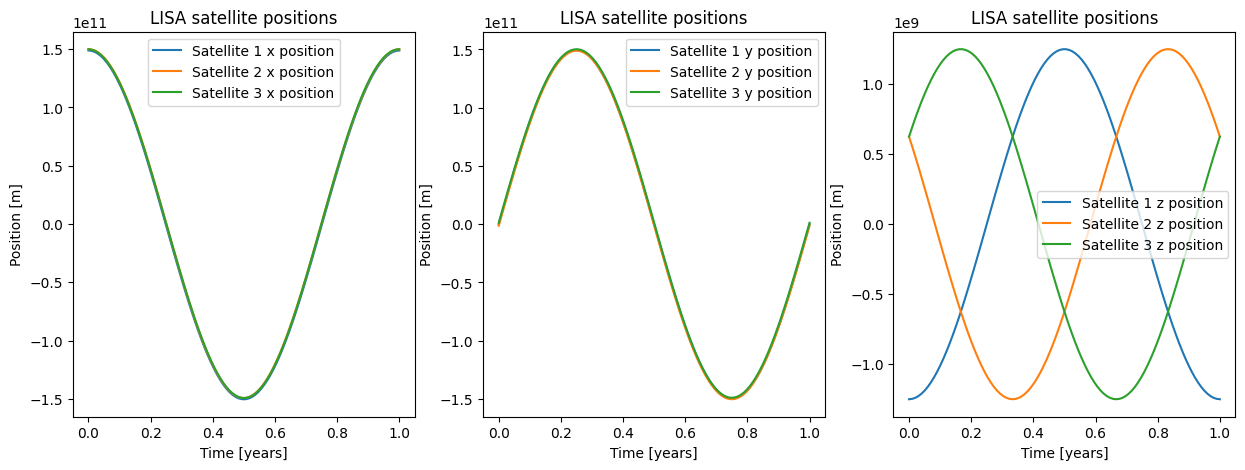

In [92]:
# Satellite positions
time_in_years = jnp.linspace(0, 1.0, 100)

fig = plt.figure(figsize=(15, 5))
for satellite in [1, 2, 3]:
    ax = plt.subplot(1, 3, 1)
    lisa_analytical_x_positions = gwr.LISA_satellite_x_coordinate_analytical(
        index=satellite,
        time_in_years=time_in_years,
        orbit_radius=gwr.PhysicalConstants().AU,
        eccentricity=gwr.LISA().ecc,
    )
    if satellite == 1:
        print(
            "lisa_analytical_x_positions shape:",
            lisa_analytical_x_positions.shape,
            "[time]",
        )
        if GENERATE_TEST_DATA:
            np.save(
                "testing/test_data/lisa_analytical_x_positions.npy",
                np.array(lisa_analytical_x_positions),
            )
    plt.plot(
        time_in_years,
        lisa_analytical_x_positions,
        label=f"Satellite {satellite} x position",
    )
    ax = plt.subplot(1, 3, 2)
    lisa_analytical_y_positions = gwr.LISA_satellite_y_coordinate_analytical(
        index=satellite,
        time_in_years=time_in_years,
        orbit_radius=gwr.PhysicalConstants().AU,
        eccentricity=gwr.LISA().ecc,
    )
    if satellite == 1:
        print(
            "lisa_analytical_y_positions shape:",
            lisa_analytical_y_positions.shape,
            "[time]",
        )
        if GENERATE_TEST_DATA:
            np.save(
                "testing/test_data/lisa_analytical_y_positions.npy",
                np.array(lisa_analytical_y_positions),
            )
    plt.plot(
        time_in_years,
        lisa_analytical_y_positions,
        label=f"Satellite {satellite} y position",
    )
    ax = plt.subplot(1, 3, 3)
    lisa_analytical_z_positions = gwr.LISA_satellite_z_coordinate_analytical(
        index=satellite,
        time_in_years=time_in_years,
        orbit_radius=gwr.PhysicalConstants().AU,
        eccentricity=gwr.LISA().ecc,
    )
    if satellite == 1:
        print(
            "lisa_analytical_z_positions shape:",
            lisa_analytical_z_positions.shape,
            "[time]",
        )
        if GENERATE_TEST_DATA:
            np.save(
                "testing/test_data/lisa_analytical_z_positions.npy",
                np.array(lisa_analytical_z_positions),
            )
    plt.plot(
        time_in_years,
        lisa_analytical_z_positions,
        label=f"Satellite {satellite} z position",
    )
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.xlabel("Time [years]")
    plt.ylabel("Position [m]")
    plt.title("LISA satellite positions")
    plt.legend()

In [93]:
# x, y, z positions can also be accessed at once
lisa_analytical_positions = gwr.LISA_satellite_coordinates_analytical(
    index=1,
    time_in_years=time_in_years,
    orbit_radius=gwr.PhysicalConstants().AU,
    eccentricity=gwr.LISA().ecc,
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/lisa_analytical_positions_sat_1.npy",
        np.array(lisa_analytical_positions),
    )
print(
    "LISA satellite positions shape:",
    lisa_analytical_positions.shape,
    "[vector, time]",
)

LISA satellite positions shape: (3, 100) [vector, time]


LISA satellite positions shape: (3, 3, 100) [satellite, vector, time]


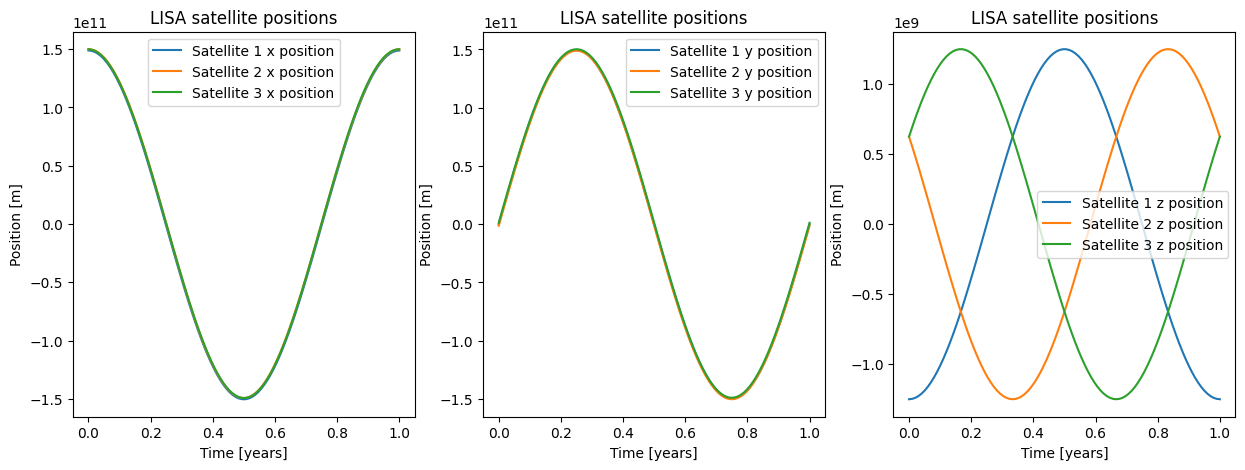

In [94]:
# or for all satellites at once
lisa_analytical_positions = gwr.LISA_satellite_coordinates_analytical_vm(
    jnp.array([1, 2, 3]),
    time_in_years,
    gwr.PhysicalConstants().AU,
    gwr.LISA().ecc,
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/lisa_analytical_positions_vm.npy",
        np.array(lisa_analytical_positions),
    )
print(
    "LISA satellite positions shape:",
    lisa_analytical_positions.shape,
    "[satellite, vector, time]",
)
fig = plt.figure(figsize=(15, 5))
for satellite_idx in [0, 1, 2]:
    ax = plt.subplot(1, 3, 1)
    plt.plot(
        time_in_years,
        lisa_analytical_positions[satellite_idx, 0, :],
        label=f"Satellite {satellite_idx + 1} x position",
    )
    ax = plt.subplot(1, 3, 2)
    plt.plot(
        time_in_years,
        lisa_analytical_positions[satellite_idx, 1, :],
        label=f"Satellite {satellite_idx + 1} y position",
    )
    ax = plt.subplot(1, 3, 3)
    plt.plot(
        time_in_years,
        lisa_analytical_positions[satellite_idx, 2, :],
        label=f"Satellite {satellite_idx + 1} z position",
    )
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.xlabel("Time [years]")
    plt.ylabel("Position [m]")
    plt.title("LISA satellite positions")
    plt.legend()

In [95]:
# Can also be accessed with LISA_satellite_positions
lisa_analytical_positions = gwr.LISA_satellite_positions(
    time_in_years,
    gwr.PhysicalConstants().AU,
    eccentricity=gwr.LISA().ecc,
    which_orbits="analytic",  # Currently only analytic implemented
)
print(
    "LISA satellite positions shape:",
    lisa_analytical_positions.shape,
    "[time, vector, satellite]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/lisa_satellite_positions.npy",
        np.array(lisa_analytical_positions),
    )

LISA satellite positions shape: (100, 3, 3) [time, vector, satellite]


LISA arms matrix shape: (100, 3, 6)


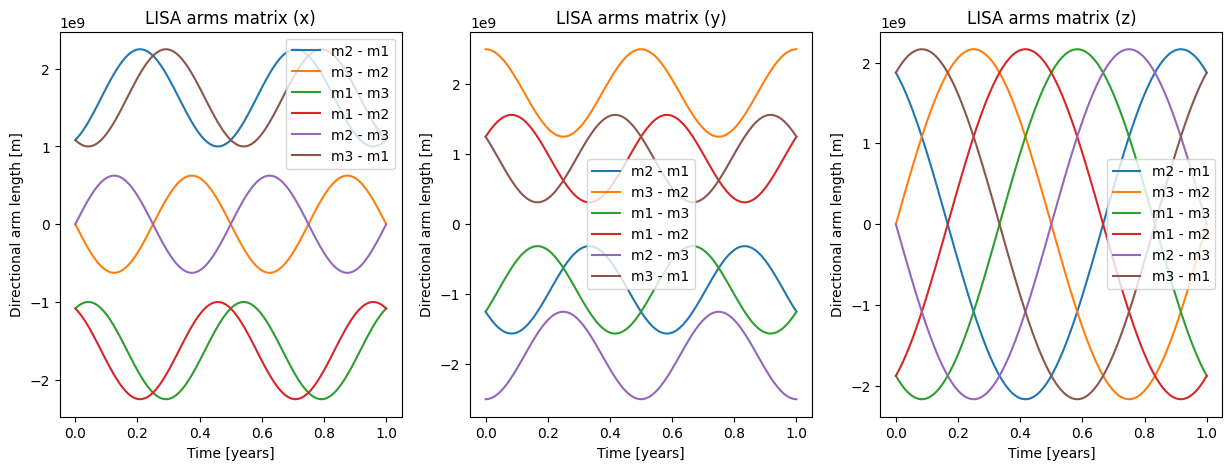

In [96]:
# Computing the unnormalised arms matrix
lisa_arms_matrix = gwr.LISA_arms_matrix_analytical(
    time_in_years, gwr.PhysicalConstants().AU, eccentricity=gwr.LISA().ecc
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/lisa_arms_matrix_analytical.npy",
        np.array(lisa_arms_matrix),
    )
print(
    "LISA arms matrix shape:", lisa_arms_matrix.shape
), "[time, xyz, arms]"  # [sat2 - sat1, sat3 - sat2, sat1 - sat3, sat1 - sat2, sat2 - sat3, sat3 - sat1]
fig = plt.figure(figsize=(15, 5))
labels = ["m2 - m1", "m3 - m2", "m1 - m3", "m1 - m2", "m2 - m3", "m3 - m1"]
titles = ["x", "y", "z"]
for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    for j in range(6):
        plt.plot(time_in_years, lisa_arms_matrix[:, i, j], label=labels[j])
    plt.legend()
    plt.xlabel("Time [years]")
    plt.ylabel("Directional arm length [m]")
    plt.title("LISA arms matrix (" + titles[i] + ")")

In [97]:
arm_lengths = jnp.sqrt(
    jnp.einsum("tij,tij->tj", lisa_arms_matrix, lisa_arms_matrix)
)
print("Arm lengths:", arm_lengths[0, :])
if GENERATE_TEST_DATA:
    np.save("testing/test_data/arm_lengths.npy", np.array(arm_lengths))

Arm lengths: [2.5e+09 2.5e+09 2.5e+09 2.5e+09 2.5e+09 2.5e+09]


In [98]:
# LISA detector object available to access all these properties
lisa = gwr.LISA()
print("LISA object:", lisa)
# Generate a given frequency grid between lisa.fmin and lisa.fmax
frequencies = lisa.frequency_vec(10)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/frequencies.npy", np.array(frequencies))
print("Frequencies:\n", frequencies)

# Compute the corresponding k vector (f * arm_length / c)
kl_vector = lisa.klvector(frequencies)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/kl_vector.npy", np.array(kl_vector))
print("kl vector:\n", kl_vector)

# or the corresponding x vector (2 pi f L / c) for a given frequency grid
x_vector = lisa.x(frequencies)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/x_vector.npy", np.array(x_vector))
print("x vector:\n", x_vector)

# Easily access satellite positions and detector arms matrix
satellite_positions = lisa.satellite_positions(time_in_years)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/satellite_positions.npy",
        np.array(satellite_positions),
    )
print("Satellite positions shape:", satellite_positions.shape)
arms_matrix = lisa.detector_arms(time_in_years)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/arms_matrix.npy", np.array(arms_matrix))
print("Arms matrix shape:", arms_matrix.shape)

LISA object: LISA(name='LISA', ps=PhysicalConstants(light_speed=299792458.0, hour=3600.0, day=86400.0, yr=31557600.0, Hubble_over_h=3.24e-18, AU=149597870700.0, cmb_dipole=Array([-0.972,  0.137, -0.191], dtype=float64)), fmin=3e-05, fmax=0.5, armlength=2500000000.0, deg=20, res=1e-06, which_orbits='analytic')
Frequencies:
 [3.00000000e-05 5.55822222e-02 1.11134444e-01 1.66686667e-01
 2.22238889e-01 2.77791111e-01 3.33343333e-01 3.88895556e-01
 4.44447778e-01 5.00000000e-01]
kl vector:
 [2.50173071e-04 4.63505842e-01 9.26761510e-01 1.39001718e+00
 1.85327285e+00 2.31652852e+00 2.77978418e+00 3.24303985e+00
 3.70629552e+00 4.16955119e+00]
x vector:
 [1.57188377e-03 2.91229309e+00 5.82301430e+00 8.73373551e+00
 1.16444567e+01 1.45551779e+01 1.74658991e+01 2.03766204e+01
 2.32873416e+01 2.61980628e+01]
Satellite positions shape: (100, 3, 3)
Arms matrix shape: (100, 3, 6)


## Module: `noise`

Implementation of the TM and OMS noise functions and projection through TDI

Text(0.5, 1.0, 'LISA noise component templates')

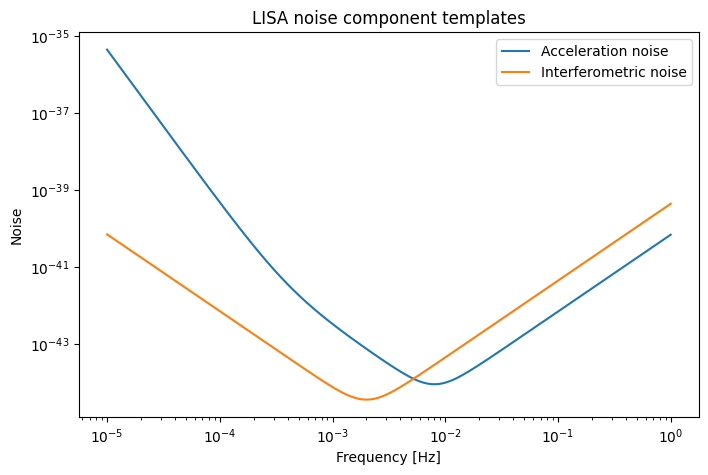

In [99]:
freqs = jnp.logspace(-5, 0, 300)
acc_noise = gwr.LISA_acceleration_noise(
    freqs, acc_param=1.0
)  # scales quadratically with acc_param
int_noise = gwr.LISA_interferometric_noise(
    freqs, inter_param=1.0
)  # scales quadratically with inter_param
if GENERATE_TEST_DATA:
    np.save("testing/test_data/acc_noise.npy", np.array(acc_noise))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/int_noise.npy", np.array(int_noise))

fig = plt.figure(figsize=(8, 5))
plt.loglog(freqs, acc_noise, label="Acceleration noise")
plt.loglog(freqs, int_noise, label="Interferometric noise")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.legend()
plt.title("LISA noise component templates")

Single link TM noise matrix shape: (100, 300, 6, 6) [time, freq, arms, arms]
TM parameters: [1. 1. 1. 1. 1. 1.]


/Users/james/Code/mambaforge/envs/saqqara-3.9/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


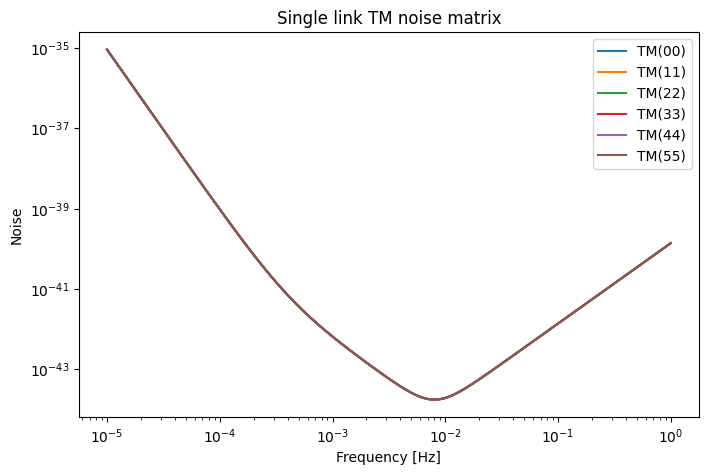

In [100]:
# Compute the single link TM noise matrix
TM_params = jnp.array(np.ones(6))
tm_noise_single_link = gwr.single_link_TM_acceleration_noise_variance(
    freqs,
    TM_acceleration_parameters=TM_params,  # Should be length 6 (for each of the arms)
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/tm_noise_single_link.npy",
        np.array(tm_noise_single_link),
    )
print(
    "Single link TM noise matrix shape:",
    tm_noise_single_link.shape,
    "[time, freq, arms, arms]",
)
fig = plt.figure(figsize=(8, 5))
for i in range(6):
    plt.loglog(
        freqs, tm_noise_single_link[0, :, i, i], label=f"TM({i}{i})"
    )  # Off-diagonal elements are zero
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("Single link TM noise matrix")
print("TM parameters:", TM_params)

Single link OMS noise matrix shape: (300, 6, 6) [time, freq, arms, arms]
OMS parameters: [1. 1. 1. 1. 1. 1.]


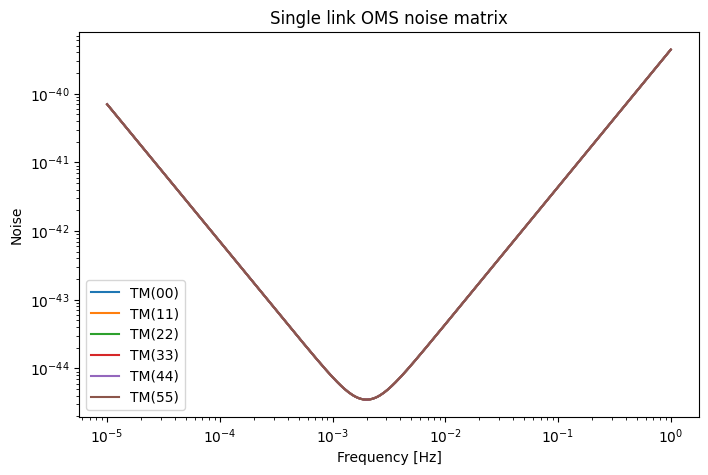

In [101]:
# Compute the single link TM noise matrix
OMS_params = jnp.array(
    np.ones(6)
)  # Should be shape [time, 6] (for each of the arms)
oms_noise_single_link = gwr.single_link_OMS_noise_variance(
    freqs,
    OMS_parameters=OMS_params,  # Should be length 6 (for each of the arms)
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "Single link OMS noise matrix shape:",
    oms_noise_single_link.shape,
    "[time, freq, arms, arms]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/oms_noise_single_link.npy",
        np.array(oms_noise_single_link),
    )
fig = plt.figure(figsize=(8, 5))
for i in range(6):
    plt.loglog(
        freqs, oms_noise_single_link[:, i, i], label=f"TM({i}{i})"
    )  # Off-diagonal elements are zero
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("Single link OMS noise matrix")
print("OMS parameters:", OMS_params)

TM TDI projection shape: (100, 300, 3, 3) [time, freq, tdi, tdi]
OMS TDI projection shape: (100, 300, 3, 3) [time, freq, tdi, tdi]


Text(0.5, 1.0, 'TDI projection')

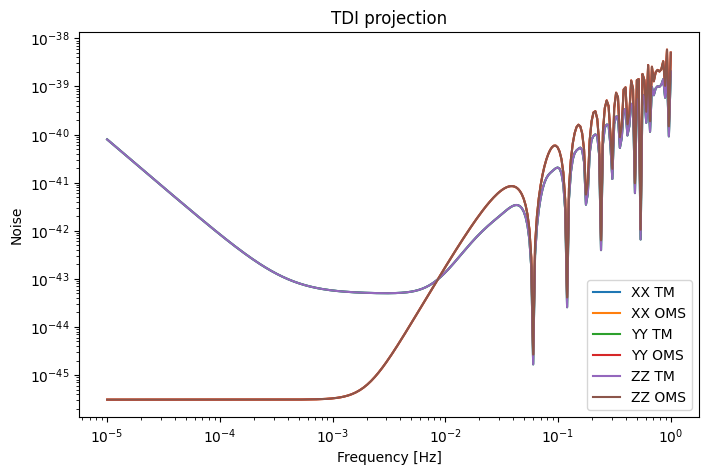

In [102]:
# TDI Projections
TM_tdi_projection = gwr.tdi_projection(
    TDI_idx=0,  # 0 = XTZ, 1 = AET, 2 = Sagnac, 3 = AET_Sagnac etc.
    single_link_mat=tm_noise_single_link,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "TM TDI projection shape:",
    TM_tdi_projection.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/tm_tdi_projection.npy", np.array(TM_tdi_projection)
    )
OMS_tdi_projection = gwr.tdi_projection(
    TDI_idx=0,  # 0 = XTZ, 1 = AET, 2 = Sagnac, 3 = AET_Sagnac etc.
    single_link_mat=oms_noise_single_link,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "OMS TDI projection shape:",
    OMS_tdi_projection.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/oms_tdi_projection.npy", np.array(OMS_tdi_projection)
    )

fig = plt.figure(figsize=(8, 5))
labels = ["XX", "YY", "ZZ"]
for i in range(3):
    plt.loglog(freqs, TM_tdi_projection[0, :, i, i], label=labels[i] + " TM")
    plt.loglog(freqs, OMS_tdi_projection[0, :, i, i], label=labels[i] + " OMS")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("TDI projection")

TM TDI projection shape: (100, 300, 3, 3) [time, freq, tdi, tdi]
OMS TDI projection shape: (100, 300, 3, 3) [time, freq, tdi, tdi]


Text(0.5, 1.0, 'TDI projection')

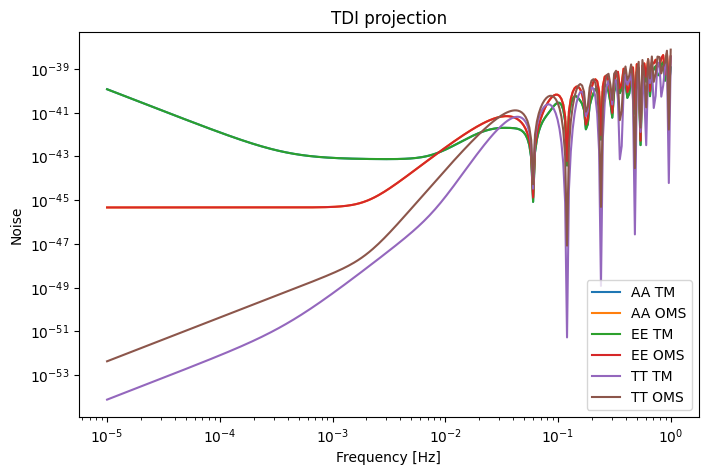

In [103]:
# TDI Projections
TM_tdi_projection = gwr.tdi_projection(
    TDI_idx=1,  # 0 = XTZ, 1 = AET, 2 = Sagnac, 3 = AET_Sagnac etc.
    single_link_mat=tm_noise_single_link,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "TM TDI projection shape:",
    TM_tdi_projection.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/tm_tdi_projection_aet.npy",
        np.array(TM_tdi_projection),
    )

OMS_tdi_projection = gwr.tdi_projection(
    TDI_idx=1,  # 0 = XTZ, 1 = AET, 2 = Sagnac, 3 = AET_Sagnac etc.
    single_link_mat=oms_noise_single_link,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "OMS TDI projection shape:",
    OMS_tdi_projection.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/oms_tdi_projection_aet.npy",
        np.array(OMS_tdi_projection),
    )

fig = plt.figure(figsize=(8, 5))
labels = ["AA", "EE", "TT"]
for i in range(3):
    plt.loglog(freqs, TM_tdi_projection[0, :, i, i], label=labels[i] + " TM")
    plt.loglog(freqs, OMS_tdi_projection[0, :, i, i], label=labels[i] + " OMS")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("TDI projection")

Text(0.5, 1.0, 'TDI projection')

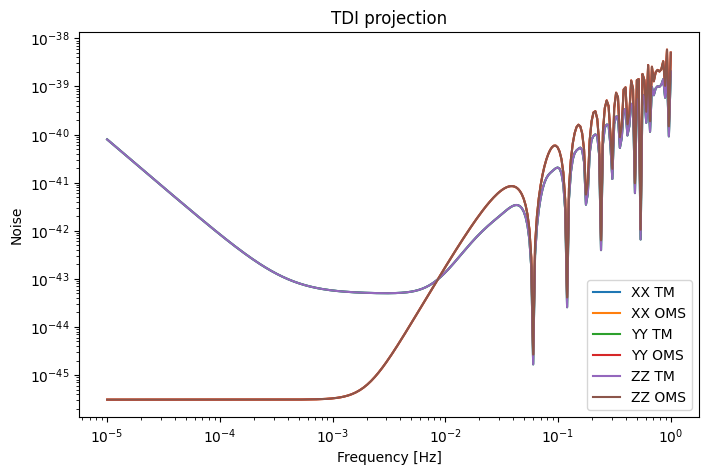

In [104]:
# This can be achieved in one step with the following
TM_tdi_matrix = gwr.noise_TM_matrix(
    TDI_idx=0,
    frequency=freqs,
    TM_acceleration_parameters=TM_params,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
OMS_tdi_matrix = gwr.noise_OMS_matrix(
    TDI_idx=0,
    frequency=freqs,
    OMS_parameters=OMS_params,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tm_tdi_matrix.npy", np.array(TM_tdi_matrix))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/oms_tdi_matrix.npy", np.array(OMS_tdi_matrix))

fig = plt.figure(figsize=(8, 5))
labels = ["XX", "YY", "ZZ"]
for i in range(3):
    plt.loglog(freqs, TM_tdi_matrix[0, :, i, i], label=labels[i] + " TM")
    plt.loglog(freqs, OMS_tdi_matrix[0, :, i, i], label=labels[i] + " OMS")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("TDI projection")

Text(0.5, 1.0, 'TDI projection')

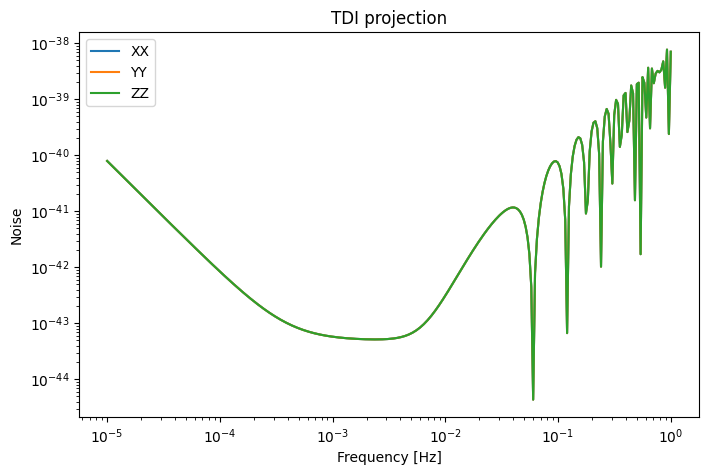

In [105]:
# Or in one combined step for TM and OMS
noise_matrix = gwr.noise_matrix(
    TDI_idx=0,
    frequency=freqs,
    TM_acceleration_parameters=TM_params,
    OMS_parameters=OMS_params,
    arms_matrix_rescaled=lisa.detector_arms(time_in_years=time_in_years)
    / lisa.armlength,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/noise_matrix.npy", np.array(noise_matrix))
fig = plt.figure(figsize=(8, 5))
labels = ["XX", "YY", "ZZ"]
for i in range(3):
    plt.loglog(freqs, noise_matrix[0, :, i, i], label=labels[i])
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Noise")
plt.title("TDI projection")

## Module: `response`

Implements a `Response` class for computing the angular and integrated response in a given detector

In [106]:
# Set up the response object
response = gwr.Response(
    ps=gwr.PhysicalConstants(),
    det=gwr.LISA(),
)

In [107]:
# Angular response
pixel = gwr.Pixel()
theta, phi = pixel.theta_pixel, pixel.phi_pixel
single_link_response = response.get_single_link_response(
    times_in_years=jnp.array([0.0]),
    theta_array=theta,
    phi_array=phi,
    frequency_array=freqs,
    polarization="LR",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/single_link_response_LL.npy",
        np.array(single_link_response["LL"]),
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/single_link_response_RR.npy",
        np.array(single_link_response["RR"]),
    )
print(
    "single_link_response shape:",
    single_link_response["LL"].shape,
    "[time, freq, arms, pixel]",
)

single_link_response shape: (1, 300, 6, 768) [time, freq, arms, pixel]


In [108]:
# Linear integrand response
linear_integrand = response.get_linear_integrand(
    times_in_years=jnp.array([0.0]),
    single_link=single_link_response,
    frequency_array=freqs,
    TDI="XYZ",
    polarization="LR",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/linear_integrand_LL.npy",
        np.array(linear_integrand["LL"]),
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/linear_integrand_RR.npy",
        np.array(linear_integrand["RR"]),
    )
print(
    "linear_integrand shape:",
    linear_integrand["LL"].shape,
    "[time, freq, arms, pixel]",
)

linear_integrand shape: (1, 300, 3, 768) [time, freq, arms, pixel]


In [109]:
# Compute the full integrated response
response.compute_detector(
    times_in_years=jnp.array([0.0]),
    theta_array=theta,
    phi_array=phi,
    frequency_array=freqs,
    TDI="XYZ",
    polarization="LR",
)
print(
    "response shape:",
    response.integrated["XYZ"]["LL"].shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/response_XYZ_LL.npy",
        np.array(response.integrated["XYZ"]["LL"]),
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/response_XYZ_RR.npy",
        np.array(response.integrated["XYZ"]["RR"]),
    )

response shape: (1, 300, 3, 3) [time, freq, tdi, tdi]


Text(0.5, 1.0, 'Integrated response')

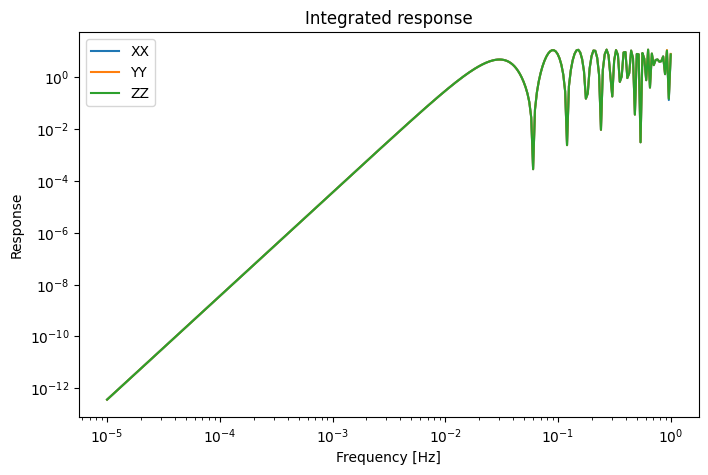

In [110]:
labels = ["XX", "YY", "ZZ"]
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    plt.loglog(
        freqs, response.integrated["XYZ"]["LL"][0, :, i, i], label=labels[i]
    )
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response")
plt.title("Integrated response")

In [111]:
# Compute the full integrated response in AET basis
response.compute_detector(
    times_in_years=jnp.array([0.0]),
    theta_array=theta,
    phi_array=phi,
    frequency_array=freqs,
    TDI="AET",
    polarization="LR",
)
print(
    "response shape:",
    response.integrated["AET"]["LL"].shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/response_AET_LL.npy",
        np.array(response.integrated["AET"]["LL"]),
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/response_AET_RR.npy",
        np.array(response.integrated["AET"]["RR"]),
    )

response shape: (1, 300, 3, 3) [time, freq, tdi, tdi]


Text(0.5, 1.0, 'Integrated response')

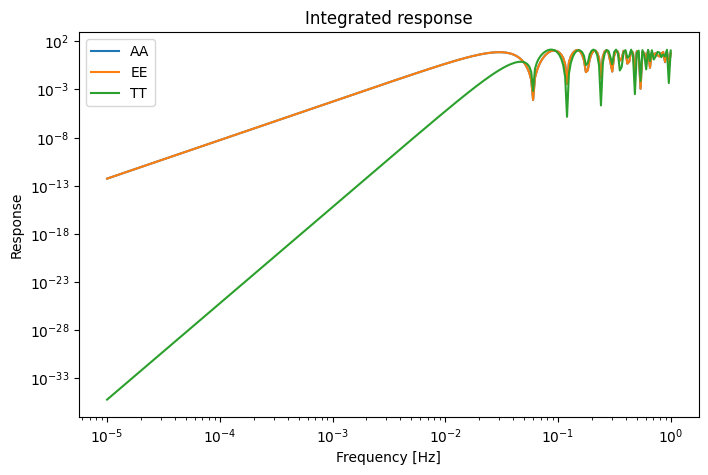

In [112]:
labels = ["AA", "EE", "TT"]
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    plt.loglog(
        freqs, response.integrated["AET"]["LL"][0, :, i, i], label=labels[i]
    )
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Response")
plt.title("Integrated response")

## Module: `single_link`

Implementation of the various helper functions to compute the single link response

In [113]:
# Compute a unit vector in the direction of theta, phi
unit_vector = gwr.unit_vec(theta, phi)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/unit_vector.npy", np.array(unit_vector))
print("unit_vector shape:", unit_vector.shape, "[xyz, pixel]")

unit_vector shape: (3, 768) [xyz, pixel]


In [114]:
# Complete an orthogonal basis for a given unit vector along theta, phi
u, v = gwr.uv_analytical(theta, phi)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/u.npy", np.array(u))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/v.npy", np.array(v))
print("u shape:", u.shape, "[pixel, xyz]")
print("v shape:", v.shape, "[pixel, xyz]")
# These can be used to compute polarization vectors
e1, e2 = gwr.polarization_vectors(u, v)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e1.npy", np.array(e1))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e2.npy", np.array(e2))
print("e1 shape:", e1.shape, "[pixel, xyz]")
print("e2 shape:", e2.shape, "[pixel, xyz]")
# Or polarisation tensors in some basis
e1p, e1c = gwr.polarization_tensors_PC(u, v)
e1L, e1R = gwr.polarization_tensors_LR(u, v)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e1p.npy", np.array(e1p))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e1c.npy", np.array(e1c))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e1L.npy", np.array(e1L))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/e1R.npy", np.array(e1R))
print("e1p shape:", e1p.shape, "[pixel, xyz, xyz]")
print("e1c shape:", e1c.shape, "[pixel, xyz, xyz]")
print("e1L shape:", e1L.shape, "[pixel, xyz, xyz]")
print("e1R shape:", e1R.shape, "[pixel, xyz, xyz]")

u shape: (768, 3) [pixel, xyz]
v shape: (768, 3) [pixel, xyz]
e1 shape: (768, 3) [pixel, xyz]
e2 shape: (768, 3) [pixel, xyz]
e1p shape: (768, 3, 3) [pixel, xyz, xyz]
e1c shape: (768, 3, 3) [pixel, xyz, xyz]
e1L shape: (768, 3, 3) [pixel, xyz, xyz]
e1R shape: (768, 3, 3) [pixel, xyz, xyz]


In [115]:
# There are a set of functions to compute the various quantities in the response
xi_k = gwr.xi_k_no_G(
    unit_wavevector=unit_vector,
    x_vector=lisa.x(freqs),
    arms_mat_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/xi_k.npy", np.array(xi_k))
print("xi_k shape:", xi_k.shape, "[time, freq, arms, pixel]")

xi_k shape: (1, 300, 6, 768) [time, freq, arms, pixel]


In [116]:
sat_positions = lisa.satellite_positions(0.0)[0]
p1, p2, p3 = sat_positions[:, 0], sat_positions[:, 1], sat_positions[:, 2]
sp1, sp2, sp3 = gwr.shift_to_center(p1, p2, p3)

In [117]:
# Or the exponential of the position
position_exp = gwr.position_exponential(
    positions_detector_frame=jnp.array([[sp1, sp2, sp3]]) / lisa.armlength,
    unit_wavevector=unit_vector,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/position_exp.npy", np.array(position_exp))
print("position_exp shape:", position_exp.shape, "[time, freq, arms, pixel]")

# Or a geometrical factor
geomtrical_factor = gwr.geometrical_factor(
    arms_matrix=lisa.detector_arms(0.0) / lisa.armlength,
    polarization_tensor=e1L,
)
print(
    "geomtrical_factor shape:", geomtrical_factor.shape, "[time, arms, pixel]"
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/geometrical_factor.npy", np.array(geomtrical_factor)
    )

# Or a different version of xi_k
xi_k_Avec = gwr.xi_k_Avec_func(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    unit_wavevector=unit_vector,
    x_vector=lisa.x(freqs),
    geometrical=geomtrical_factor,
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/xi_k_Avec.npy", np.array(xi_k_Avec))
print("xi_k_Avec shape:", xi_k_Avec.shape, "[time, freq, arms, pixel]")

position_exp shape: (1, 300, 3, 768) [time, freq, arms, pixel]
geomtrical_factor shape: (1, 6, 768) [time, arms, pixel]
xi_k_Avec shape: (1, 300, 6, 768) [time, freq, arms, pixel]


single_link_response shape: (1, 300, 6, 768) [time, freq, arms, pixel]


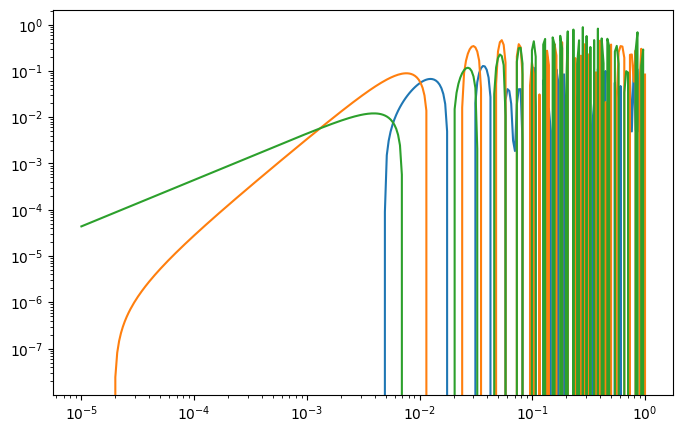

In [118]:
# With these we can compute the single link response
geomtrical_factor = gwr.geometrical_factor(
    arms_matrix=lisa.detector_arms(0.0) / lisa.armlength,
    polarization_tensor=e1L,
)
xi_k_Avec = gwr.xi_k_Avec_func(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    unit_wavevector=unit_vector,
    x_vector=lisa.x(freqs),
    geometrical=geomtrical_factor,
)
single_link_response = gwr.single_link_response(
    positions=lisa.satellite_positions(0.0) / lisa.armlength,
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    wavevector=unit_vector,
    x_vector=lisa.x(freqs),
    xi_k_Avec=xi_k_Avec,
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/single_link_response.npy",
        np.array(single_link_response),
    )
print(
    "single_link_response shape:",
    single_link_response.shape,
    "[time, freq, arms, pixel]",
)
fig = plt.figure(figsize=(8, 5))
for i in range(3):
    plt.loglog(freqs, single_link_response[0, :, i, 0])
plt.show()

linear_response_tdi shape: (1, 300, 3, 768) [time, freq, tdi, pixels]


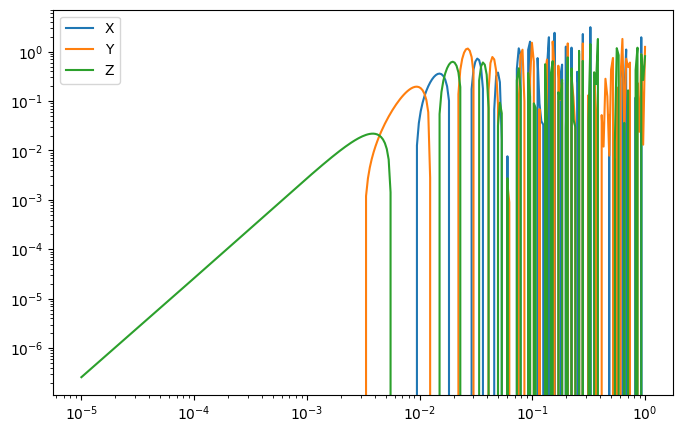

In [119]:
# Ths can be used to compute the linear angular response in the TDI basis
linear_response_tdi = gwr.linear_response_angular(
    TDI_idx=0,  # XYZ basis
    single_link=single_link_response,
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "linear_response_tdi shape:",
    linear_response_tdi.shape,
    "[time, freq, tdi, pixels]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/linear_response_tdi.npy",
        np.array(linear_response_tdi),
    )
fig = plt.figure(figsize=(8, 5))
labels = ["X", "Y", "Z"]
for i in range(3):
    plt.loglog(freqs, linear_response_tdi[0, :, i, 0], label=labels[i])
plt.legend()

quadratic_angular_response shape: (1, 300, 3, 3, 768) [time, freq, tdi, tdi, pixels]


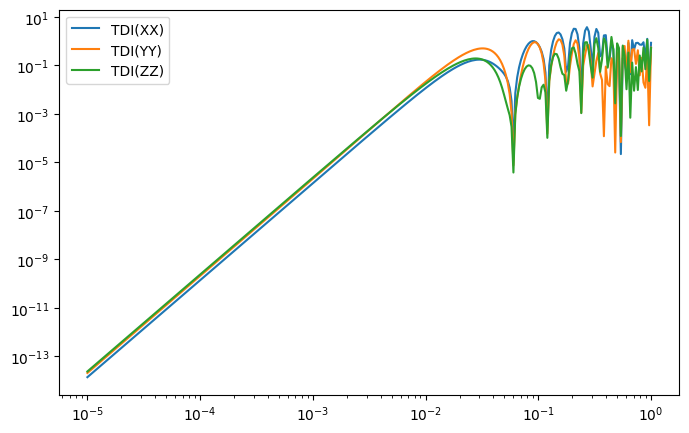

In [120]:
# Or the quadratic response
quadratic_angular_response = gwr.response_angular(
    TDI_idx=0,  # XYZ basis
    single_link=single_link_response,
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "quadratic_angular_response shape:",
    quadratic_angular_response.shape,
    "[time, freq, tdi, tdi, pixels]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/quadratic_angular_response.npy",
        np.array(quadratic_angular_response),
    )
fig = plt.figure(figsize=(8, 5))
labels = ["XX", "YY", "ZZ"]
for i in range(3):
    plt.loglog(
        freqs,
        quadratic_angular_response[0, :, i, i, 0],
        label=f"TDI({labels[i]})",
    )
plt.legend()

integrated_response shape: (1, 300, 3, 3) [time, freq, tdi, tdi]


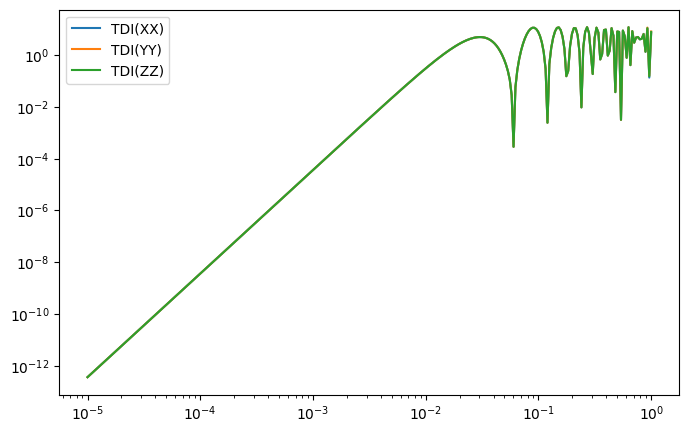

In [121]:
# This angular response can be used to compute the integrated response averaged over the sky
integrated_response = gwr.response_integrated(quadratic_angular_response)
print(
    "integrated_response shape:",
    integrated_response.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/integrated_response.npy",
        np.array(integrated_response),
    )
fig = plt.figure(figsize=(8, 5))
labels = ["XX", "YY", "ZZ"]
for i in range(3):
    plt.loglog(
        freqs, integrated_response[0, :, i, i], label=f"TDI({labels[i]})"
    )
plt.legend()

integrated_response shape: (1, 300, 3, 3) [time, freq, tdi, tdi]


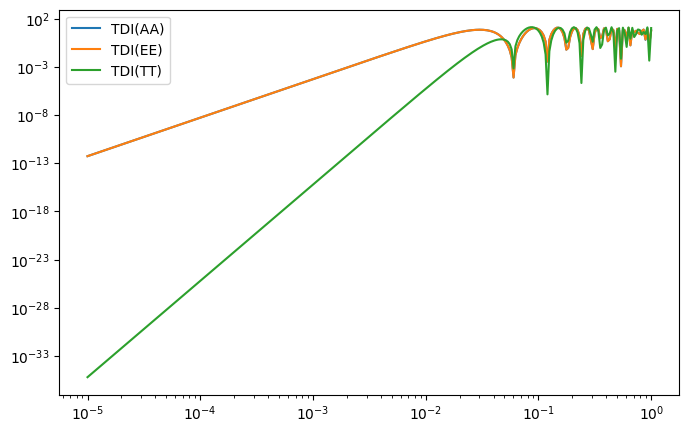

In [122]:
# Or in the AET basis
quadratic_angular_response_AET = gwr.response_angular(
    TDI_idx=1,  # AET basis
    single_link=single_link_response,
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
integrated_response = gwr.response_integrated(quadratic_angular_response_AET)
print(
    "integrated_response shape:",
    integrated_response.shape,
    "[time, freq, tdi, tdi]",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/integrated_response_AET.npy",
        np.array(integrated_response),
    )
fig = plt.figure(figsize=(8, 5))
labels = ["AA", "EE", "TT"]
for i in range(3):
    plt.loglog(
        freqs, integrated_response[0, :, i, i], label=f"TDI({labels[i]})"
    )
plt.legend()

## Module: `tdi`

Implements relevant functions for computing the TDI basis transformations

In [123]:
# Sine factors
sine_factors = gwr.sin_factors(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/sine_factors.npy", np.array(sine_factors))
print("sine_factors shape:", sine_factors.shape, "[time, freq, arms]")

sine_factors shape: (1, 300, 6) [time, freq, arms]


In [124]:
# Or the various TDI matrices
tdi_XYZ = gwr.tdi_XYZ_matrix(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_XYZ shape:", tdi_XYZ.shape, "[time, freq, tdi, arms]")

tdi_zeta = gwr.tdi_zeta_matrix(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_zeta shape:", tdi_zeta.shape, "[time, freq, tdi, arms]")

tdi_Sagnac = gwr.tdi_Sagnac_matrix(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_Sagnac shape:", tdi_Sagnac.shape, "[time, freq, tdi, arms]")

tdi_AET = gwr.tdi_AET_matrix(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_AET shape:", tdi_AET.shape, "[time, freq, tdi, arms]")

tdi_AET_Sagnac = gwr.tdi_AET_Sagnac_matrix(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_AET_Sagnac shape:", tdi_AET_Sagnac.shape, "[time, freq, tdi, arms]")
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_XYZ.npy", np.array(tdi_XYZ))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_zeta.npy", np.array(tdi_zeta))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_Sagnac.npy", np.array(tdi_Sagnac))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_AET.npy", np.array(tdi_AET))
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_AET_Sagnac.npy", np.array(tdi_AET_Sagnac))

tdi_XYZ shape: (1, 300, 3, 6) [time, freq, tdi, arms]
tdi_zeta shape: (1, 300, 3) [time, freq, tdi, arms]
tdi_Sagnac shape: (1, 300, 3, 6) [time, freq, tdi, arms]
tdi_AET shape: (1, 300, 3, 6) [time, freq, tdi, arms]
tdi_AET_Sagnac shape: (1, 300, 3, 6) [time, freq, tdi, arms]


In [125]:
# The relevant tdi matrxi can be accessed using the function tdi_matrix
tdi_matrix = gwr.tdi_matrix(
    TDI_idx=0,  # XYZ basis
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_matrix_XYZ.npy", np.array(tdi_matrix))
print("tdi_matrix shape:", tdi_matrix.shape, "[time, freq, tdi, arms]")
# This chooses from the TDI_map dictionary:
print(gwr.TDI_map)
tdi_matrix = gwr.tdi_matrix(
    TDI_idx=gwr.TDI_map["AET_Sagnac"],  # AET Sagnac basis
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("tdi_matrix shape:", tdi_matrix.shape, "[time, freq, tdi, arms]")
if GENERATE_TEST_DATA:
    np.save("testing/test_data/tdi_matrix_AET_Sagnac.npy", np.array(tdi_matrix))

tdi_matrix shape: (1, 300, 3, 6) [time, freq, tdi, arms]
{'XYZ': 0, 'AET': 1, 'Sagnac': 2, 'AET_Sagnac': 3}
tdi_matrix shape: (1, 300, 3, 6) [time, freq, tdi, arms]


In [126]:
# Given a TDI matrix, can then project any single link response onto the correct TDI basis
tdi_projection = gwr.build_tdi(
    TDI_idx=gwr.TDI_map["XYZ"],  # XYZ basis
    single_link=single_link_response,
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print(
    "tdi_projection shape:", tdi_projection.shape, "[time, freq, tdi, pixels]"
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/tdi_projection_XYZ.npy", np.array(tdi_projection)
    )

tdi_projection shape: (1, 300, 3, 768) [time, freq, tdi, pixels]


## Module `utils`

Implements a few helper functions relevant to e.g. the pixelisation of the sky and computing complex exponentials

Number of pixels: 768
theta shape: (768,)
phi shape: (768,)
angular map shape: (768, 2)


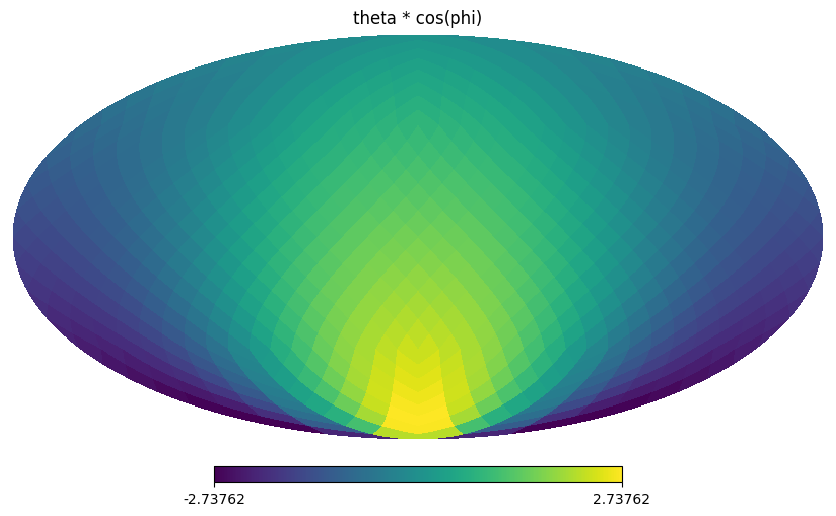

In [127]:
# Pixel class
pixel_class = gwr.Pixel(NSIDE=8)
print("Number of pixels:", pixel_class.NPIX)
print("theta shape:", pixel_class.theta_pixel.shape)
print("phi shape:", pixel_class.phi_pixel.shape)
print("angular map shape:", pixel_class.angular_map.shape)
hp.mollview(
    pixel_class.theta_pixel * jnp.cos(pixel_class.phi_pixel),
    title="theta * cos(phi)",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/pixel_theta.npy", np.array(pixel_class.theta_pixel)
    )
if GENERATE_TEST_DATA:
    np.save("testing/test_data/pixel_phi.npy", np.array(pixel_class.phi_pixel))
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/pixel_angular_map.npy",
        np.array(pixel_class.angular_map),
    )

Number of pixels: 3072
theta shape: (3072,)
phi shape: (3072,)
angular map shape: (3072, 2)


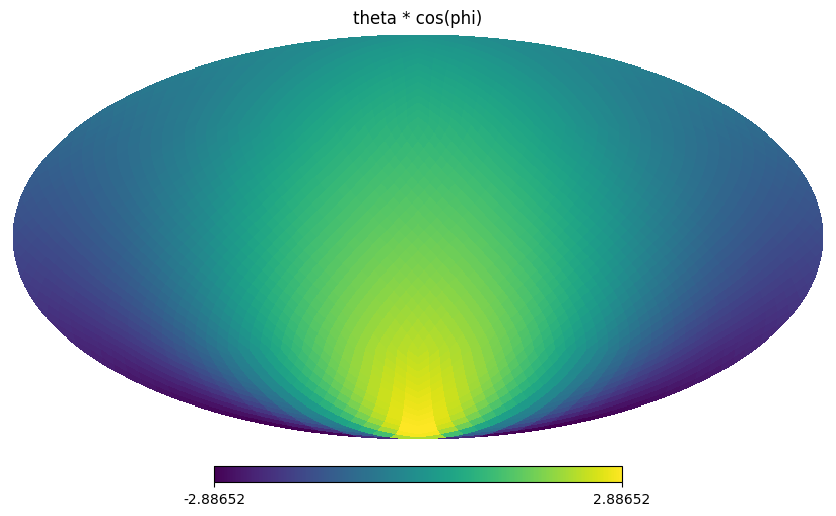

In [128]:
# Can also change the value of NSIDE dynamically
pixel_class.change_NSIDE(NSIDE=16)
print("Number of pixels:", pixel_class.NPIX)
print("theta shape:", pixel_class.theta_pixel.shape)
print("phi shape:", pixel_class.phi_pixel.shape)
print("angular map shape:", pixel_class.angular_map.shape)
hp.mollview(
    pixel_class.theta_pixel * jnp.cos(pixel_class.phi_pixel),
    title="theta * cos(phi)",
)
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/pixel_theta_16.npy",
        np.array(pixel_class.theta_pixel),
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/pixel_phi_16.npy", np.array(pixel_class.phi_pixel)
    )
if GENERATE_TEST_DATA:
    np.save(
        "testing/test_data/pixel_angular_map_16.npy",
        np.array(pixel_class.angular_map),
    )

In [129]:
# Some helper functions to compute e.g. the arms length exponential
arm_length_exp = gwr.arm_length_exponential(
    arms_matrix_rescaled=lisa.detector_arms(0.0) / lisa.armlength,
    x_vector=lisa.x(freqs),
)
print("arm_length_exp shape:", arm_length_exp.shape, "[time, freq, arms]")
if GENERATE_TEST_DATA:
    np.save("testing/test_data/arm_length_exp.npy", np.array(arm_length_exp))

# Or shift a set of positions to the centre
sp1, sp2, sp3 = gwr.shift_to_center(p1, p2, p3)
print("New centre of mass (~[0, 0, 0]):", sp1 + sp2 + sp3)

arm_length_exp shape: (1, 300, 6) [time, freq, arms]
New centre of mass (~[0, 0, 0]): [-5.60283661e-06  2.38418579e-07  1.19209290e-07]
